In [ ]:
from __future__ import print_function
import argparse
import os
import random

import torch
import torch.nn as nn
import torch.nn.parallel
import torch.backends.cudnn as cudnn
import torch.optim as optim
import torch.utils.data
import torchvision.datasets as dset
import torchvision.transforms as transforms
import torchvision.utils as vutils
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.animation as animation

import numpy as np
import pandas as pd
from PIL import Image
import time
import glob
import imageio
import cv2
import pathlib
import zipfile
import sys
import pandas as pd

import torchvision
from torch.utils.data import Dataset, DataLoader, ConcatDataset, TensorDataset
from torchvision.utils import make_grid
import torch.optim as optim
from torchvision.datasets import MNIST

from skimage import io, transform

from IPython import display
from IPython.display import HTML
manualSeed = 999
random.seed(manualSeed)
torch.manual_seed(manualSeed)

In [ ]:
pip install graphviz

In [ ]:
!pip install torchsummary
! pip install torchview
from torchsummary import summary
import torchvision
from torchview import draw_graph

In [ ]:
dataroot = "/content/drive/MyDrive/GAN_MRI_Image"
workers = 2
batch_size = 128
image_size = 128
nc = 1
nz = 100
ngf = image_size
ndf = image_size
ngpu = 1

In [ ]:
def seed_worker(worker_id):
    worker_seed = torch.initial_seed() % 2**32
    np.random.seed(worker_seed)
    random.seed(worker_seed)

In [ ]:
dataset = dset.ImageFolder(root=dataroot,
                           transform=transforms.Compose([
                               transforms.Grayscale(),
                               transforms.Resize((image_size, image_size)),
#                                transforms.CenterCrop(image_size),
                               transforms.ToTensor(),
                               transforms.Normalize(mean=[0.5], std=[0.5]),
                           ]))
dataloader = torch.utils.data.DataLoader(dataset, batch_size=batch_size,
                                         shuffle=True, num_workers=workers)

device = torch.device("cuda:0" if (torch.cuda.is_available() and ngpu > 0) else "cpu")

In [ ]:
class Generator (nn.Module):
    """ a model generates fake images """
    def __init__ (self, z_dim=100, img_channels=1, features_g=32):
        super (Generator, self).__init__ ()

        # Input: N x z_dim x 1 x 1
        self.gen = nn.Sequential (
            self._block (z_dim, features_g * 32, 4, 2, 0),                               # 4x4
            self._block (features_g * 32, features_g * 16, 4, 2, 1),                      # 8x8
            self._block (features_g * 16, features_g * 8, 4, 2, 1),                       # 16x16
            self._block (features_g * 8, features_g * 4, 4, 2, 1),                       # 32x32
            self._block (features_g * 4, features_g * 2, 4, 2, 1),                       # 64x64
            nn.ConvTranspose2d (
                features_g * 2, img_channels, kernel_size = 4, stride = 2, padding = 1), # 128x128
            nn.Tanh ()
        )



    def _block (self, in_channels, out_channels, kernel_size, stride, padding):
        return nn.Sequential (
            nn.ConvTranspose2d (in_channels, out_channels, kernel_size, stride, padding, bias = False),
            nn.BatchNorm2d (out_channels),
            nn.ReLU ()
        )

    def forward (self, x):
        return self.gen (x)
summary(Generator().to(device), (nz,1,1))
print(Generator(z_dim = nz, img_channels = 1, features_g = 32))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
   ConvTranspose2d-1           [-1, 1024, 4, 4]       1,638,400
       BatchNorm2d-2           [-1, 1024, 4, 4]           2,048
              ReLU-3           [-1, 1024, 4, 4]               0
   ConvTranspose2d-4            [-1, 512, 8, 8]       8,388,608
       BatchNorm2d-5            [-1, 512, 8, 8]           1,024
              ReLU-6            [-1, 512, 8, 8]               0
   ConvTranspose2d-7          [-1, 256, 16, 16]       2,097,152
       BatchNorm2d-8          [-1, 256, 16, 16]             512
              ReLU-9          [-1, 256, 16, 16]               0
  ConvTranspose2d-10          [-1, 128, 32, 32]         524,288
      BatchNorm2d-11          [-1, 128, 32, 32]             256
             ReLU-12          [-1, 128, 32, 32]               0
  ConvTranspose2d-13           [-1, 64, 64, 64]         131,072
      BatchNorm2d-14           [-1, 64,

In [ ]:
##########################
### MODEL
##########################

import torch.nn.functional as F

class Critic(torch.nn.Module):

    def __init__(self, num_classes=2):
        super(Critic, self).__init__()

        #########################
        ### 1st residual block
        #########################
        self.conv_1 = torch.nn.Conv2d(in_channels=1,
                                      out_channels=4,
                                      kernel_size=(3, 3),
                                      stride=(2, 2),
                                      padding=1)
        self.conv_1_bn = torch.nn.InstanceNorm2d(4)

        self.conv_2 = torch.nn.Conv2d(in_channels=4,
                                      out_channels=8,
                                      kernel_size=(1, 1),
                                      stride=(1, 1),
                                      padding=0)
        self.conv_2_bn = torch.nn.InstanceNorm2d(8)

        self.conv_shortcut_1 = torch.nn.Conv2d(in_channels=1,
                                               out_channels=8,
                                               kernel_size=(1, 1),
                                               stride=(2, 2),
                                               padding=0)
        self.conv_shortcut_1_bn = torch.nn.InstanceNorm2d(8)

        #########################
        ### 2nd residual block
        #########################
        self.conv_3 = torch.nn.Conv2d(in_channels=8,
                                      out_channels=16,
                                      kernel_size=(3, 3),
                                      stride=(2, 2),
                                      padding=1)
        self.conv_3_bn = torch.nn.InstanceNorm2d(16)

        # 7x7x16 => 7x7x32
        self.conv_4 = torch.nn.Conv2d(in_channels=16,
                                      out_channels=32,
                                      kernel_size=(1, 1),
                                      stride=(1, 1),
                                      padding=0)
        self.conv_4_bn = torch.nn.InstanceNorm2d(32)

        # 14x14x8 => 7x7x32
        self.conv_shortcut_2 = torch.nn.Conv2d(in_channels=8,
                                               out_channels=32,
                                               kernel_size=(1, 1),
                                               stride=(2, 2),
                                               padding=0)
        self.conv_shortcut_2_bn = torch.nn.InstanceNorm2d(32)

        #########################
        ### 3nd residual block
        #########################
        self.conv_5 = torch.nn.Conv2d(in_channels=32,
                                      out_channels=64,
                                      kernel_size=(3, 3),
                                      stride=(2, 2),
                                      padding=1)
        self.conv_5_bn = torch.nn.InstanceNorm2d(64)

        self.conv_6 = torch.nn.Conv2d(in_channels=64,
                                      out_channels=128,
                                      kernel_size=(1, 1),
                                      stride=(1, 1),
                                      padding=0)
        self.conv_6_bn = torch.nn.InstanceNorm2d(128)

        self.conv_shortcut_3 = torch.nn.Conv2d(in_channels=32,
                                               out_channels=128,
                                               kernel_size=(1, 1),
                                               stride=(2, 2),
                                               padding=0)
        self.conv_shortcut_3_bn = torch.nn.InstanceNorm2d(128)


        #########################
        ### Fully connected
        #########################
        self.flat=nn.Flatten()

        self.linear_1 = torch.nn.Linear(16*16*128, num_classes)
        self.final=nn.Sigmoid()



        self.relu = nn.LeakyReLU(0.2, inplace=True)
        # self.relu = nn.ReLU()

    def forward(self, x):

        #########################
        ### 1st residual block
        #########################
        shortcut = x

        out = self.conv_1(x) # 28x28x1 => 14x14x4
        out = self.conv_1_bn(out)
        out = self.relu(out)

        out = self.conv_2(out) # 14x14x4 => 714x14x8
        out = self.conv_2_bn(out)
                # match up dimensions using a linear function (no relu)
        shortcut = self.conv_shortcut_1(shortcut)
        shortcut = self.conv_shortcut_1_bn(shortcut)

        out += shortcut
        out = self.relu(out)

        #########################
        ### 2nd residual block
        #########################

        shortcut = out

        out = self.conv_3(out)
        out = self.conv_3_bn(out)
        out = F.relu(out)

        out = self.conv_4(out)
        out = self.conv_4_bn(out)

        # match up dimensions using a linear function (no relu)
        shortcut = self.conv_shortcut_2(shortcut)
        shortcut = self.conv_shortcut_2_bn(shortcut)

        out += shortcut
        out = self.relu(out)

        #########################
        ### 3rd residual block
        #########################

        shortcut = out

        out = self.conv_5(out)
        out = self.conv_5_bn(out)
        out = self.relu(out)

        out = self.conv_6(out)
        out = self.conv_6_bn(out)

        # match up dimensions using a linear function (no relu)
        shortcut = self.conv_shortcut_3(shortcut)
        shortcut = self.conv_shortcut_3_bn(shortcut)

        out += shortcut
        out = self.relu(out)

        #########################
        ### Fully connected
        #########################
        out=self.flat(out)
        out = self.linear_1(out)
        out=self.final(out)

        return out


model = Critic()
model = model.to(device)

In [ ]:
def get_noise(n_samples, nz, device='cpu'):
    return torch.randn(n_samples,nz,1,1,device=device)

In [ ]:
fixed_noise = get_noise(batch_size, nz, device=device)

In [ ]:
fixed_noise = get_noise(batch_size, nz, device=device)

Time is 49.09100794792175 sec
Shape of loading one batch: torch.Size([128, 1, 128, 128])
Total no. of batches present in trainloader: 116


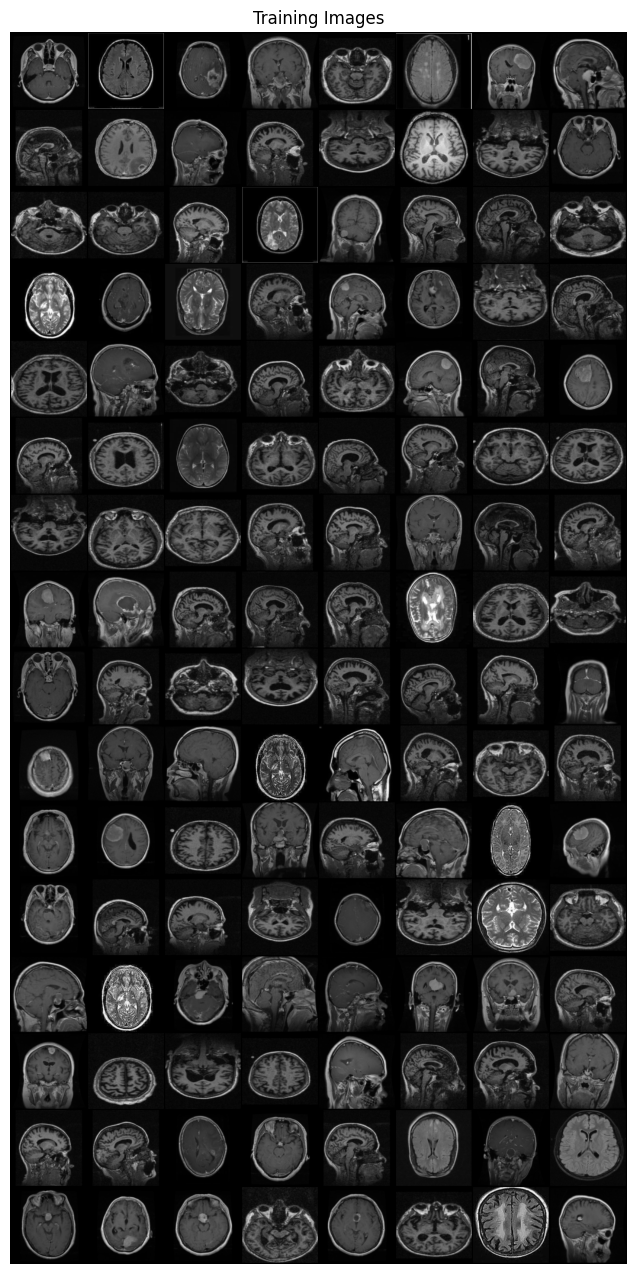

In [ ]:
start = time.time()
dataiter = iter(dataloader)
images,labels = dataiter.__next__()
print ('Time is {} sec'.format(time.time()-start))

plt.figure(figsize=(16,16))
plt.axis("off")
plt.title("Training Images")
plt.imshow(np.transpose(make_grid(images.to(device), padding=2, normalize=True).cpu(),(1,2,0)))

print('Shape of loading one batch:', images.shape)
print('Total no. of batches present in trainloader:', len(dataloader))

In [ ]:
def gradient_penalty(gradient):
    gradient = gradient.view(len(gradient), -1)

    gradient_norm = gradient.norm(2, dim=1)

    penalty = torch.mean((gradient_norm - 1)**2)
    return penalty

In [ ]:
def get_gen_loss(crit_fake_pred):
    gen_loss = -1. * torch.mean(crit_fake_pred)
    return gen_loss

In [ ]:
def get_crit_loss(crit_fake_pred, crit_real_pred, gp, c_lambda):
    crit_loss = torch.mean(crit_fake_pred) - torch.mean(crit_real_pred) + c_lambda * gp
    return crit_loss

In [ ]:
def get_gradient(crit, real, fake, epsilon):

    mixed_images = real * epsilon + fake * (1 - epsilon)

    mixed_scores = crit(mixed_images)

    gradient = torch.autograd.grad(
        inputs=mixed_images,
        outputs=mixed_scores,
        grad_outputs=torch.ones_like(mixed_scores),
        create_graph=True,
        retain_graph=True,

    )[0]
    return gradient


In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

lr_g = 0.0002
lr_c = 0.0002
beta_1 = 0.0
beta_2 = 0.999



def weights_init(m):
    classname = m.__class__.__name__
    if classname.find('Conv') != -1:
        nn.init.normal_(m.weight.data, 0.0, 0.02)
    elif classname.find('BatchNorm') != -1:
        nn.init.normal_(m.weight.data, 1.0, 0.02)
        nn.init.constant_(m.bias.data, 0)


criterion = nn.BCELoss()


gen = Generator().to(device)
crit  = Critic().to(device)

if (device.type == 'cuda') and (ngpu > 1):
    gen = nn.DataParallel(gen, list(range(ngpu)))


gen_opt = torch.optim.RMSprop(gen.parameters(), lr=lr_g)
crit_opt = torch.optim.RMSprop(crit.parameters(), lr=lr_c)


gen = gen.apply(weights_init)
crit = crit.apply(weights_init)

In [ ]:
def show_tensor_images(image_tensor, num_images=25, size=(nc, image_size, image_size), show_fig=False, epoch=0):
    image_unflat = image_tensor.detach().cpu().view(-1, *size)
    image_grid = make_grid(image_unflat[:num_images], nrow=5,normalize=True)
    plt.axis('off')
    plt.imshow(image_grid.permute(1, 2, 0).squeeze())
    if show_fig:
        plt.savefig('gez_images_128_2\image_at_epoch_{:04d}.png'.format(epoch))

    plt.show()

In [ ]:
n_epochs = 500
cur_step = 0
total_steps = 0
start_time = time.time()
cur_step = 0

generator_losses = []
critic_losses = []

C_mean_losses = []
G_mean_losses = []

c_lambda = 10
crit_repeats = 5
display_step = 50

img_list = []
iters = 0


for epoch in range(n_epochs):
    cur_step = 0
    start = time.time()
    i=0
    for real, _ in dataloader:
        cur_batch_size = len(real)
        real = real.to(device)

        mean_iteration_critic_loss = 0
        for _ in range(crit_repeats):
            ### Update critic ###
            crit_opt.zero_grad()
            fake_noise = get_noise(cur_batch_size, nz, device=device)
            fake = gen(fake_noise)
            crit_fake_pred = crit(fake.detach())
            crit_real_pred = crit(real)

            epsilon = torch.rand(len(real), 1, 1, 1, device=device, requires_grad=True)
            gradient = get_gradient(crit, real, fake.detach(), epsilon)
            gp = gradient_penalty(gradient)
            crit_loss = get_crit_loss(crit_fake_pred, crit_real_pred, gp, c_lambda)

            # Keep track of the average critic loss in this batch
            mean_iteration_critic_loss += crit_loss.item() / crit_repeats
            # Update gradients
            crit_loss.backward(retain_graph=True)
            # Update optimizer
            crit_opt.step()
        critic_losses += [mean_iteration_critic_loss]

        ### Update generator ###
        gen_opt.zero_grad()
        fake_noise_2 = get_noise(cur_batch_size, nz, device=device)
        fake_2 = gen(fake_noise_2)
        crit_fake_pred = crit(fake_2)

        gen_loss = get_gen_loss(crit_fake_pred)
        gen_loss.backward()

        # Update the weights
        gen_opt.step()

        # Keep track of the average generator loss
        generator_losses += [gen_loss.item()]

        cur_step += 1
        total_steps += 1

        print_val = f"Epoch: {epoch}/{n_epochs} Steps:{cur_step}/{len(dataloader)}\t"
        print_val += f"Epoch_Run_Time: {(time.time()-start):.6f}\t"
        print_val += f"Loss_C : {mean_iteration_critic_loss:.6f}\t"
        print_val += f"Loss_G : {gen_loss:.6f}\t"
        print(print_val, end='\r',flush = True)



        if (iters % 500 == 0) or ((epoch == n_epochs-1) and (i == len(dataloader)-1)):
            with torch.no_grad():
                fake = gen(fixed_noise).detach().cpu()
            img_list.append(vutils.make_grid(fake, padding=2, normalize=True))

        iters += 1
        i+=1



        # Visualization code ###
        if cur_step % display_step == 0 and cur_step > 0:
            print()
            gen_mean = sum(generator_losses[-display_step:]) / display_step
            crit_mean = sum(critic_losses[-display_step:]) / display_step
            print(f"Step {cur_step}: Generator loss: {gen_mean}, critic loss: {crit_mean}")
            show_tensor_images(fake)
            show_tensor_images(real)
            step_bins = 20
            num_examples = (len(generator_losses) // step_bins) * step_bins
            plt.plot(
                range(num_examples // step_bins),
                torch.Tensor(generator_losses[:num_examples]).view(-1, step_bins).mean(1),
                label="Generator Loss"
            )
            plt.plot(
                range(num_examples // step_bins),
                torch.Tensor(critic_losses[:num_examples]).view(-1, step_bins).mean(1),
                label="Critic Loss"
            )
            plt.legend()
            plt.show()

    print()
    gen_mean = sum(generator_losses[-cur_step:]) / cur_step
    crit_mean = sum(critic_losses[-cur_step:]) / cur_step

    C_mean_losses.append(crit_mean)
    G_mean_losses.append(gen_mean)

    print_val = f"Epoch: {epoch}/{n_epochs} Total Steps:{total_steps}\t"
    print_val += f"Total_Time : {(time.time() - start_time):.6f}\t"
    print_val += f"Loss_C : {mean_iteration_critic_loss:.6f}\t"
    print_val += f"Loss_G : {gen_loss:.6f}\t"
    print_val += f"Loss_C_Mean : {crit_mean:.6f}\t"
    print_val += f"Loss_G_Mean : {gen_mean:.6f}\t"
    print(print_val)

    fake_noise = fixed_noise
    fake = gen(fake_noise)

    show_tensor_images(fake, show_fig=True,epoch=epoch)

    cur_step = 0

In [ ]:
torch.save(gen.state_dict(), "generator340_res_3.pt")
torch.save(crit.state_dict(), "discrimanator340_res_3.pt")

In [ ]:
plt.figure(figsize=(10,5))
plt.title("Generator and Discriminator Loss During Training")
plt.plot(generator_losses,label="G-Loss")
plt.plot(critic_losses,label="C-Loss")
plt.xlabel("iterations")
plt.ylabel("Loss")
plt.legend()
plt.show()

In [ ]:
plt.figure(figsize=(10,5))
plt.title("Generator and Discriminator Loss During Training")
plt.plot(G_mean_losses,label="G-Loss")
plt.plot(C_mean_losses,label="C-Loss")
plt.xlabel("iterations")
plt.ylabel("Loss")
plt.legend()
plt.show()

In [ ]:
def show_new_gen_images(tensor_img, num_img=25):
    tensor_img = (tensor_img + 1) / 2
    unflat_img = tensor_img.detach().cpu()
    img_grid = make_grid(unflat_img[:num_img], nrow=5)
    plt.imshow(img_grid.permute(1, 2, 0).squeeze(),cmap='gray')
    plt.show()

num_image = 25
noise = get_noise(num_image, nz, device=device)
with torch.no_grad():
    fake_img = gen(noise)

show_new_gen_images(fake_img.reshape(num_image,nc,image_size,image_size))

In [ ]:
real_batch = next(iter(dataloader))

plt.figure(figsize=(30,30))
plt.subplot(1,2,1)
plt.axis("off")
plt.title("Real Images")
plt.imshow(np.transpose(vutils.make_grid(real_batch[0].to(device), padding=5, normalize=True).cpu(),(1,2,0)))

plt.subplot(1,2,2)
plt.axis("off")
plt.title("Fake Images")
plt.imshow(np.transpose(img_list[-1],(1,2,0)))
plt.savefig('compare.png',dpi=300)
plt.show()

In [ ]:
anim_file = 'WGAN-GAN_128_Res_ins.gif'

with imageio.get_writer(anim_file, mode='I') as writer:
  filenames = glob.glob(r'gez_images_128_2\image*.png')
  filenames = sorted(filenames)
  for filename in filenames:
    image = imageio.imread(filename)
    writer.append_data(image)
  image = imageio.imread(filename)
  writer.append_data(image)


# !pip install -q git+https://github.com/tensorflow/docs
import tensorflow_docs.vis.embed as embed
embed.embed_file(anim_file